# Image Classification - Softmax Regression

## Table of Contents
* [Introduction](#Introduction)
* [Requirements](#Requirements) 
  * [Knowledge](#Knowledge)
  * [Modules](#Python-Modules)
  * [Data](#Data)
* [Load, Explore and Prepare Dataset](#Load,-Explore-and-Prepare-Dataset)
* [Exercises](#Exercises)
 * [Plot Digits](#Plot-Digits)
 * [Preparation of Train- and Test-Split](#Preparation-of-Train--and-Test-Split)
 * [Define a Linear Classifier Using Softmax](#Define-a-Linear-Classifier-Using-Softmax)
 * [Reduce the Cost Using Gradient Descent](#Reduce-the-Cost-Using-Gradient-Descent)
 * [Stochastical Gradient Descent](#Stochastical-Gradient-Descent)
 * [Evaluate the Vanilla Gradient Descent Model](#Evaluate-the-Vanilla-Gradient-Descent-Model)
 * [Evaluate the Stochastical Gradient Descent Model](#Evaluate-the-Stochastical-Gradient-Descent-Model)
* [Appendix](#Appendix)
 * [Predicting an Own Example](#Predicting-an-Own-Example)
  * [Preparation](#Preparation)
 * [Creating an Own Batch](#Creating-an-Own-Batch)
 * [Evaluation](#Evaluation)
 * [Normalize our Images](#Normalize-our-Images)
 * [Evaluation](#Evaluation)
* [Summary and Outlook](#Summary-and-Outlook)
* [Literature](#Literature)
* [Licenses](#Licenses)

## Introduction

In this exercise you will learn how to classify images of handwritten digits. For classification you will implement the logistic regression, or better said, as we have more than two classes, softmax regression. Further you will learn about _stochastic gradient descent_ (opposed to _gradient descent_) and for evaluation of your model, the accuracy and f1-score.

## Requirements

### Knowledge

Required knowledge:

- Machine learning models linear models
- Gradient descent.
- Softmax 

##### Literature:
- Lecture Notes of CS231n: [Linear classification: Support Vector Machine, Softmax](https://cs231n.github.io/linear-classify/) .
- Eli Bendersky [blog post](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/) about
Softmax and its derivative.


### Python Modules

With the deep.TEACHING convention, all python modules needed to run the notebook are loaded centrally at the beginning. 

In [1]:
# All necessary imports at the beginning
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil
import gzip
import urllib.request
import pandas as pd

## Load, Explore and Prepare Dataset

The MNIST dataset is a classic Machine Learning dataset you can get it and more information about it from the website of [Yann Lecun](http://yann.lecun.com/exdb/mnist/). MNIST contains handwrittin digits and is split into a trainings set of 60000 examples and a test set of 10000 examples. You can use the module ```sklearn``` to load the MNIST dataset in a convenient way. 
easy load, mldata.org, orginal mnist, mnist link and description

**Note:**

If the cells below throws an error, the problem might be a broken download link. In that case, download the dataset from another source, e.g. from https://www.kaggle.com/avnishnish/mnist-original, and unzip it and place it under `BASE_DATA_DIR`.

In [2]:
BASE_DATA_DIR = os.path.expanduser('~/deep.TEACHING/data')

class Mnist:
    """Downloads, loads into numpy array and reshapes the common machine learning dataset: MNIST

    The MNIST dataset contains handwritten digits, available from http://yann.lecun.com/exdb/mnist/,
    has a training set of 60,000 examples, and a test set of 10,000 examples. With the class you can
    download the dataset and prepare them for usage, e.g., flatten the images or hot-encode the labels.
    """

    def __init__(self, data_dir=None, auto_download=True, verbose=True):
        """Downloads and moves MNIST dataset in a given folder.

        MNIST will be downloaded from http://yann.lecun.com/exdb/mnist/ and moved
        into the folder 'data_dir', if a path is given by the user, else files
        will be moved into a folder specified by the deep-teaching-commons
        config file.

        Args:
            data_dir: A string representing a path where you want to store MNIST.
            auto_download: A boolean, if True and the given 'data_dir' does not exists, MNIST will be download.
            verbose: A boolean indicating more user feedback or not.
        """
        self.data_dir = data_dir
        self.verbose = verbose

        if self.data_dir is None:
            self.data_dir = os.path.join(BASE_DATA_DIR, 'MNIST')

        self.data_url = 'http://yann.lecun.com/exdb/mnist/'
        self.files = ['train-images-idx3-ubyte.gz','train-labels-idx1-ubyte.gz','t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz']

        if auto_download:
            if self.verbose:
                print('auto download is active, attempting download')
            self.download()

    def download(self):
        """Downloads MNIST dataset.

        Creates a directory, downloads MNIST and moves the data into the
        directory. MNIST source and target directory are defined by
        class initialization (__init__).

        TODO:
            Maybe redesign so it can be used as standalone method.
        """
        if os.path.exists(self.data_dir):
            if self.verbose:
                print('mnist data directory already exists, download aborted')
        else:
            if self.verbose:
                print('data directory does not exist, starting download...')
            # Create directories
            os.makedirs(self.data_dir)
            # Download each file and move it to given self.data_dir
            for file in self.files:
                urllib.request.urlretrieve(self.data_url + file, file)
                shutil.move(file, os.path.join(self.data_dir, file))
                if self.verbose:
                        print(file,'successfully downloaded')
            if self.verbose:
                print('... mnist data completely downloaded, enjoy.')

    def get_all_data(self, one_hot_enc=None, flatten=True, normalized=None):
        """Loads MNIST dataset into four numpy arrays.

        Default setup will return training and test images in a flat resprensentaion,
        meaning each image is row of 28*28 (784) pixel values. Labels are encoded as
        digit between 0 and 9. You can change both representation using the arguments,
        e.g., to preserve the image dimensions.

        Args:
            one_hot_enc (boolean): Indicates if labels returned in standard (0-9) or one-hot-encoded form
            flatten (boolean): Images will be returned as vector (flatten) or as matrix
            normalized (boolean): Indicates if pixels (0-253) will be normalized

        Returns:
            train_data (ndarray): A matrix containing training images
            train_labels (ndarray): A vector containing training labels
            test_data (ndarray): A matrix containing test images
            test_labels (ndarray): A vector containing test labels
        """
        train_images = self.get_images(os.path.join(self.data_dir,self.files[0]))
        train_labels = self.get_labels(os.path.join(self.data_dir,self.files[1]))
        test_images = self.get_images(os.path.join(self.data_dir,self.files[2]))
        test_labels = self.get_labels(os.path.join(self.data_dir,self.files[3]))

        if one_hot_enc:
            train_labels, test_labels = [self.to_one_hot_enc(labels) for labels in (train_labels, test_labels)]

        if flatten is False:
            train_images, test_images = [images.reshape(-1,28,28) for images in (train_images, test_images)]

        if normalized:
            train_images, test_images = [images/np.float32(256) for images in (train_images, test_images)]

        return train_images, train_labels, test_images, test_labels

    def get_images(self, file_path):
        """Unzips, reads and reshapes image files.

        Args:
            file_path (string): mnist image data file

        Returns:
            ndarray: A matrix containing flatten images
        """
        with gzip.open(file_path, 'rb') as file:
            images = np.frombuffer(file.read(), np.uint8, offset=16)
        return images.reshape(-1, 28 * 28)

    def get_labels(self, file_path):
        """Unzips and read label file.

        Args:
            file_path (string): mnist label data file

        Returns:
            ndarray: A vector containing labels
        """
        with gzip.open(file_path, 'rb') as file:
            labels = np.frombuffer(file.read(), np.uint8, offset=8)
        return labels


    def to_one_hot_enc(self, labels):
        """Converts standard MNIST label representation into an one-hot-encoding.

        Converts labels into a one-hot-encoding representation. It is done by
        manipulating a one diagonal matrix with fancy indexing.

        Args:
            labels (ndarray): Array of mnist labels

        Returns:
            ndarray: A matrix containing a one-hot-encoded label each row

        Example:
            [2,9,0] --> [[0,0,1,0,0,0,0,0,0,0]
                         [0,0,0,0,0,0,0,0,0,1]
                         [1,0,0,0,0,0,0,0,0,0]]
        """
        return np.eye(10)[labels]


In [3]:
mnist = Mnist()
X_train_, y_train, X_test_, y_test = mnist.get_all_data(one_hot_enc=True, flatten=True)

auto download is active, attempting download
mnist data directory already exists, download aborted


In [5]:
# for the Bias-Trick: add a one column at the beginning of the data matricies
M_train = X_train_.shape[0]
X_train = np.concatenate((np.ones((M_train, 1)), X_train_), axis=1)
M_test = X_test_.shape[0]
X_test = np.concatenate((np.ones((M_test, 1)), X_test_), axis=1)

#### Task 

Explain the bias trick.


To get a visualization of MNIST we will plot a digit. Each line represents an image in flatten form (all pixel in a row). We have change the shape from a vector back to a matrix of the original shape to plot the image. In the case of MNIST this means a conversion of 784 pixel into 28x28 pixel. In addition we will check the label of that digit to verify it correspond to the image.

label: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


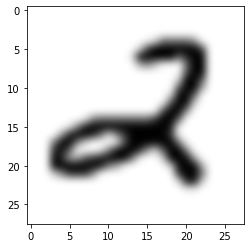

In [33]:
def plot_mnist_digit(digit):
    image = digit.reshape(28, 28)
    plt.imshow(image, cmap='binary', interpolation='bicubic')

#choose a random number, plot it and check label 
random_number = np.random.randint(1,len(X_train)-1)
print('label:',y_train[random_number]) 
plot_mnist_digit(X_train_[random_number])

## Exercises

### Plot Digits

After a glimpse into MNIST let us explore it a bit further. 

**Task:**

Write a function ``` plot_mnist_digits(data, examples_each_row)``` that plots configurable number of examples for each class, like:
![internet connection needed](https://gitlab.com/deep.TEACHING/educational-materials/raw/master/media/voigt/images/MNIST_matrix.png)


In [7]:
def plot_mnist_digits(X, y, examples_each_row):
    ############################################
    #TODO: Write a function that plots as many #    
    #      examples of each class as defined   #
    #      by 'examples_each_row'              #
    ############################################
    
    pass 
    #raise NotImplementedError()
    
    
    ############################################
    #             END OF YOUR CODE             #
    ############################################
    
plot_mnist_digits(X_train, y_train, examples_each_row=10)

### Preparation of Train- and Test-Split

After exploring MNIST let us prepare the date for our linear classifier. First we will shuffle the training data to get a random distribution.  

In [11]:
# shuffle training data
shuffle_index = np.random.permutation(len(X_train))
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Define a Linear Classifier Using Softmax

#### Softmax Regression Model

First a linear transformation of the data is performed to calculate the 
_logits_ or _score_ values (before _softmax_). Note that $\vec f$ is a vector.

$$\vec f(\vec x) = \vec x^T \cdot \Theta $$
with 
- $\vec x^{(m)}$ is the $m$-th training image (as vector). $\vec x_0^{(m)}=1$ is an additional _bias_.
- $K$ is the number of classes (10 for MNIST) and $k$ is the class index.
- $M$ is the number of training examples.
- $N$ is the number of features (image pixels).
- $\Theta$: Parameter matrix with $N+1$ rows and $K$ columns. 

Each element $f_k$ of $\vec f(\vec x)$ is the logit value of the $k$-th class. 
So, $f_{y^{(m)}}(\vec x^{(m)})$ is the logit value
   of the label class $y^{(m)}$ for image $\vec x^{(m)}$.

From $\vec f$ the prediction probabilities are computed by softmax:

$$\vec h(\vec x) = \text{softmax} (\vec f ( \vec x  ))$$

The elements of $\vec h$ are $h_k(\vec x)$.  $h_k(\vec x)$ are the predicted probabilities 
that $\vec x$ belongs to class $k$:

 $$h_k(\vec x) = p( \text{class} = k \mid \vec x; \Theta)$$
 
So,
$$
h_{y^{(m)}}(\vec x) = \frac{ \exp\left({f_{y^{(m)}}(\vec x^{(m)}; \Theta)}\right)}{\sum_{k=1}^{K}\exp\left({f_k(\vec x^{(m)}; \Theta)}\right)} 
$$
 is the predicted probability for the label class of image $m$:
 



#### Tasks

Answer the following questions about _softmax_ :


1. What is the _range_ (possible values) of the softmax function?
2. What is the sum of all softmax outputs?
2. Assume the logit of output $k$ is increased a little bit (the other logits stay constant).
How changes the softmax of output $k$? How change the other softmax outputs?




#### Cost function

We will train a model to classify the MNIST dataset with the following equation for the cost function (loss):

$$ J(\Theta) = \frac{1}{M} \sum_{m=1}^{M} - \log\; \frac{ \exp\left({f_{y^{(m)}}(\vec x^{(m)}; \Theta)}\right)}{\sum_{k=1}^{K}\exp\left({f_k(\vec x^{(m)}; \Theta)}\right)}  + \lambda \sum_{k=1}^{K}\sum_{n=1}^{N} \Theta_{nk}^2 \label{eq:cost_function} \tag{1} $$

with 
- $J(\Theta)$: Cost function (also called loss $L$)



#### Tasks

Answer the following questions about the cost function:

1. What is the meaning of the first term of equation $\eqref{eq:cost_function}$? 
$$\frac{1}{M} \sum_{m=1}^{M} - \log\; \frac{ \exp\left({f_{y^{(m)}}(\vec x^{(m)}; \Theta)}\right)}{\sum_{k=1}^{K}\exp\left({f_k(\vec x^{(m)}; \Theta)}\right)} $$ 


2. What is the meaning of the second term of equation $\eqref{eq:cost_function}$?
$$
\frac{\lambda}{2} \sum_{k=1}^{K}\sum_{n=1}^{N} \Theta_{nk}^2
$$
What is the function of this term?

3. How many parameters $Q$ has the matrix $\Theta$? Note: Don't forget the bias terms.

4. Explain why 
$$ 
- \log\; \frac{ \exp\left({f_{y^{(m)}}(\vec x^{(m)}; \Theta)}\right)}{\sum_{k=1}^{K}\exp\left({f_k(\vec x^{(m)}; \Theta)}\right)} 
$$
is equivalent to
$$
- {f_{y^{(m)}}(\vec x^{(m)}; \Theta)} + \log \sum_{k=1}^{K}\exp\left({f_k(\vec x^{(m)}; \Theta)}\right)
$$

5. For the gradient descent implementation (see below) we need the gradient. Show that the components of the gradient are
$$
\frac{\partial \log h_k(\vec x, \Theta)}{\partial \Theta_{ni}} = \left(\delta_{ki} - \text{softmax}_i(\vec f(\vec x))\right) x_n
$$
Hint: Use the chain rule:
$$
\frac{\partial \log h_k}{\partial \Theta_{ni}} = \frac{\partial \log h_k}{\partial f_j}\frac{\partial f_j}{\partial \Theta_{ni}}
$$
$\delta_{ki}$ is the Kronecker Delta, i.e. 
  - $\delta_{ki}=1$, if $k=i$
  - $\delta_{ki}=0$, if $k\neq i$


#### Side Note: Probabilistic interpretation

Note that $$h_k(\vec x; \Theta) = p( k \mid \vec x; \Theta)$$ 

with 
- $p( k \mid \vec x; \Theta)$ predicted probability that image $\vec x$ belongs to class $k$.

So, 
$$
\begin{align}
J(\Theta) &= \frac{1}{M} \sum_{m=1}^{M} - \log\; \frac{ \exp\left({f_{y^{(m)}}(\vec x^{(m)}; \Theta)}\right)}{\sum_{k=1}^{K}\exp\left({f_k(\vec x^{(m)}; \Theta)}\right)}  + \frac{\lambda}{2} \sum_{k=1}^{K}\sum_{n=1}^{N} \Theta_{nk}^2  \\
&= \frac{1}{M} \sum_{m=1}^{M} L^{(m)}  + \frac{\lambda}{2} \sum_{k=1}^{K}\sum_{n=1}^{N} \Theta_{nk}^2
\end{align}
$$


$$ L^{(m)} = 
- \log\; \frac{ \exp\left({f_{y^{(m)}}(\vec x^{(m)}; \Theta)}\right)}{\sum_{k=1}^{K}\exp\left({f_k(\vec x^{(m)}; \Theta)}\right)}=- \log h_{y^{(m)}}(\vec x; \Theta) = - \log p( y^{(m)} \mid \vec x; \Theta)
$$

- $L^{(m)}$ seen as a function of $\Theta$ is (point-wise) negative log-_likelihood_.

Using the universal equation for the cost function we can see the separate parts of that hugh equation.  

$$ J(\Theta) = \frac{1}{M} \sum_i L^{(m)} + \lambda R(\Theta)$$

We will implement each part on its own and put them together. That way it is much easier to understand whats going on. 


**Task:**

Let us start with the logits / class scores:

$$F(X;\Theta) = X \cdot \Theta$$

It is possible to calculate all score values with one matrix multiplication ([dot product](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.dot.html)). So, we can use the whole training data $X$ instead of one digit image $\vec x^{(m)}$. With the numpy dot product it's much faster than using python loops.

In [12]:
def class_scores(X, theta):
    ############################################
    #TODO: Implement the hypothesis and return #
    #      the score values for each class of  #
    #      every digit.                        #
    ############################################
    raise NotImplementedError()
    ############################################
    #             END OF YOUR CODE             #
    ############################################


First, let's implement the data dependent loss $L^{(m)}$. 

<!-- We assume the score values are _unnormalized_ log-probabilities 

and we use the softmax function to calculate probabilities.
$$ P(Y=j\mid X=x_i) = \frac{e^{s_j}}{\sum_{k=1}^{K}e^{s_k}} $$
$$ L_i = -log\;P(Y=j\mid X=x_i) $$-->

Note, that `y_train` is one hot encoded.

In [14]:
y_train[:3]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

**Task:**

Implement the functions `softmax` and `data_loss`.

- `softmax` calculates the prediction probabilities ($h_k(\vec x; \Theta)$) from the class scores $f_k(\vec x; \Theta)$ for a whole (mini-)batch, e.g. $H(X;\Theta)$ from $F(X;\Theta)$. The output is an 2-D numpy array with shape (M,K).


- `data_loss` calculates the $L^{(m)}$ for a whole (mini-)batch. The output is an numpy array with shape (M,), i.e. the $L^{(m)}$ are the elements of the 1-D array.

**Hint:**

The correct classes (labels) are in a [one hot encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) shape, so you can use a matrix multiplication to extract the correct class. 

In [15]:
# Calculate class probability distribution for each digit from given class scores
def softmax(class_scores):
    ############################################
    #TODO: Use the softmax function to compute #
    #      class probabilties                  #
    ############################################    
    raise NotImplementedError()
    ############################################
    #             END OF YOUR CODE             #
    ############################################

# Compute data_loss L_i for the correct class
def data_loss(class_probabilities, onehot_encode_label):
    ############################################
    #TODO: With hot encoded labels and class   #
    #      probabilties calculate data loss    #
    #      L_i                                 #
    ############################################
    raise NotImplementedError()
    ############################################
    #             END OF YOUR CODE             #
    ############################################
    

Now, we will calculate the total cost $J(\Theta)$ using the defined functions. 

$$ J(\Theta) = \frac{1}{M} \sum_m L^{(m)} + \lambda R(\Theta)$$

We will have to calculate the gradient for our cost function $J$ with the aim to minimize the cost. 

$$ {\displaystyle \operatorname {grad} (J(\Theta))=
\vec \nabla J(\Theta)={\begin{pmatrix}{\frac {\partial J(\Theta)}{\partial \theta_{1}}}\\\vdots \\{\frac {\partial J(\Theta)}{\partial \theta_{Q}}}\end{pmatrix}}.} $$

- The total number of parameters is $Q = K (N+1)$

**Task:**

Implement the total cost (`total_cost`).

In [17]:
def total_cost(X, Y, theta, lambda_):
    # X is the design (data) matrix
    # Y are the targets one hot encoded.
    # theta are the parameter as matrix
    # lambda_ is a hyperparameter for the regularization strength
    
    H = softmax(class_scores(X,theta))  
    loss_Lm = data_loss(probabilities, encoded_labels) 
    
                             
    ############################################
    #TODO: Put everthing together and calculate #
    #      the total cost with given            #
    #      variables.                           #
    ############################################
    raise NotImplementedError()
    
    ############################################
    #             END OF YOUR CODE             #
    ############################################


#### Pen and Paper task

Show that from
$$
   \Theta_{nk}^{new} \leftarrow \Theta_{nk}^{old} - \frac{\alpha}{M} \sum_{m=1}^M \frac{\partial \log h_{y^{(m)}}(\vec x^{(m)}, \Theta^{old})}{\partial \Theta_{nk}} = \Theta_{nk}^{old} - \frac{\alpha}{M}\left( \sum_{m=1}^M\left( \text{softmax}_k(\vec f(\vec x^{(m)}; \Theta^{old})) - \delta_{{y^{(m)}}k} \right) x_n^{(m)} \right)
$$

follows (for our batch implementation) of gradient descent (without the regularization term!):

$$
\Theta^{new} \leftarrow \Theta^{old} - \frac{\alpha}{M} \left( X^T \cdot (H-Y^{OH}) \right)
$$

- $H$ is the softmax output as matrix with shape (M, K).
- $Y_{OH}$ are the targets _one-hot encoded_. $Y_{OH}$ has shape (M, K).
- $X$ is the data matrix with shape (M, N+1) (bias units added).


##### Implementation task

Implement the `gradient`-function:

In [19]:
def gradient(X, Y, theta, lambda_):

    H = softmax(class_scores(X, theta))
    
    ############################################
    #TODO: Put everthing together and calculate #
    #      the gradient with given              #
    #      variables.                           #
    #############################################
    raise NotImplementedError()
    
    ############################################
    #             END OF YOUR CODE             #
    ############################################
    
    


### Reduce the Cost Using Gradient Descent

Gradient descent is a way to minimize our Loss functions. It iteratively moves toward a set of parameter values that minimize our Loss function. This iterative minimization is achieved using calculus, taking steps in the negative direction of the  gradient (which is a vector that shows us the highest rise).

$$ {\displaystyle \vec {\theta} _{new}=\vec {\theta} _{old}- \alpha \cdot \vec \nabla J(\Theta)}$$

with
- $\alpha$: learning rate
- $\vec \theta$ is the "vectorized" version of all parameters $\Theta$ (Not used directly in implementation). 

$$ {\displaystyle {\begin{pmatrix} \theta_1 \\\vdots \\ \theta_Q \end{pmatrix}}_{new} =  {\begin{pmatrix} \theta_1 \\\vdots \\ \theta_Q \end{pmatrix}}_{old}
 -\alpha \space {\begin{pmatrix}{\frac {\partial L}{\partial \theta_{1}}}\\\vdots \\{\frac {\partial L}{\partial \theta_{Q}}}\end{pmatrix}}.} $$

In [21]:
def gradient_descent(training_data, training_label, theta, lambda_=0.5, iterations=100, learning_rate=1e-5):
    losses = []
  
    for i in range(iterations):
        loss = total_cost(training_data, training_label, theta, lambda_)
        grad = gradient(training_data, training_label, theta, lambda_)
        losses.append(loss)
        theta -= (learning_rate * grad) 
        print('epoch ', i, ' - cost ', loss)
  
    return theta, losses

# Initialize learnable parameters theta 
theta = np.zeros([X_train.shape[1], len(y_train[0])])
# Start optimization with training data, theta and optional hyperparameters
opt_theta, loss_history = gradient_descent(X_train, y_train, theta, iterations=150)

epoch  0  - cost  2.3025850929940437
epoch  1  - cost  1.7197897851355572
epoch  2  - cost  1.387485258940546
epoch  3  - cost  1.1929807653996316
epoch  4  - cost  1.0868315460700073
epoch  5  - cost  0.9945089665450335
epoch  6  - cost  0.9695409713501421
epoch  7  - cost  0.8473984293629602
epoch  8  - cost  0.8234311786304473
epoch  9  - cost  0.7673577315626103
epoch  10  - cost  0.752781368811333
epoch  11  - cost  0.7033928420297415
epoch  12  - cost  0.6864613136856771
epoch  13  - cost  0.6538235456234421
epoch  14  - cost  0.637204605670394
epoch  15  - cost  0.6151595630022962
epoch  16  - cost  0.6005959137029724
epoch  17  - cost  0.5852636364046391
epoch  18  - cost  0.573317563047066
epoch  19  - cost  0.5620636975816435
epoch  20  - cost  0.5524483890101036
epoch  21  - cost  0.5436879596788453
epoch  22  - cost  0.5358468786084982
epoch  23  - cost  0.5286794103483146
epoch  24  - cost  0.5221030465038602
epoch  25  - cost  0.5160129505540578
epoch  26  - cost  0.51033

### Stochastical Gradient Descent
In stoachstical gradient descent the gradient is computed with one or a few training examples (also called minibatch) as opposed to the whole data set (gradient descent). When the data-set is very large, SGD converges much faster, as more updates on the wheights (thetas) are done. 

A typical minibatch size is 256, although the optimal size of the minibatch can vary for different applications and architectures.

In [22]:
def sgd(training_data, training_label, theta, lambda_=0.5, 
        iterations=100, learning_rate=1e-5, batch_size=256):
    losses = []
    for i in range(iterations):
        shuffle_index = np.random.permutation(training_data.shape[0])
        data, label = training_data[shuffle_index], training_label[shuffle_index]
        data, label = data[:batch_size], label[:batch_size]
        
        l = total_cost(data, label, theta, lambda_)
        grad = gradient(data, label, theta, lambda_)
        losses.append(l)
        theta -= learning_rate * grad
    return theta, losses

# Initialize learnable parameters theta 
theta = np.zeros([X_train.shape[1],len(y_train[0])])
# Start optimization with training data, theta and optional hyperparameters
opt_theta_sgd, loss_history_sgd = sgd(X_train, y_train, theta, iterations=250)

#### Task: Anwer the following questions

1. Explain all steps in the Gradient Descent Algorithm. 
 - Explain the update rule intuitively.
1. Explain the difference between Gradient Descent and Stochastic Gradient Descent.
 - What is a mini-batch?
 - Why is SGD used for larger data sets?
1. Here we don't used _feature scaling_ 
 - Have you an idea why it's not necessary for image data.
 - Why is _feature scaling_ used normally?
 - Do the negative gradient point in general to the minimum?

### Evaluate the Vanilla Gradient Descent Model
Let us look at the optimization results. Final loss tells us how far we could reduce costs during training process. Further we can use the first loss value as a sanity check and validate our implementation of the loss function works as intended. Recall loss value after first iteration should be approximatly $-\log(1/c)=\log(c)$ with $c$ being number of classes. To visulize the whole trainings process we can plot the loss values from each iteration as a loss curve. 

last iteration loss: 0.35346114237833437
first iteration loss: 2.3025850929940437
Is the first loss equal to ln(10)? True


Text(0.5, 0, 'iterations')

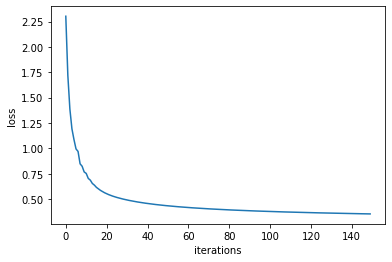

In [23]:
# check loss after last iteration
print('last iteration loss:',loss_history[-1])
# Sanity check: first loss should be ln(10)
print('first iteration loss:',loss_history[0])
print('Is the first loss equal to ln(10)?', np.log(10) - loss_history[0] < 0.000001)
# Plot a loss curve
plt.plot(loss_history)
plt.ylabel('loss')
plt.xlabel('iterations')

Evaluation above gave us some inside about the optimization process but did not quantified our final model. One possibility is to calculate model accuracy.

In [24]:
def modelAccuracy(X,y,theta):
    print(X.shape)
    print(y.shape)
    print(theta.shape)  
    # calculate probabilities for each digit
    probabilities = softmax(np.dot(X,theta))
    # class with highest probability will be predicted
    prediction = np.argmax(probabilities,axis=1)
    # Sum all correct predictions and divied by number of data
    accuracy = (sum(prediction == np.argmax(y, axis=1)))/X.shape[0]
    return accuracy

print('Training accuracy: ', modelAccuracy(X_train,y_train,opt_theta))
print('Test accuracy: ', modelAccuracy(X_test,y_test,opt_theta))

(60000, 785)
(60000, 10)
(785, 10)
Training accuracy:  0.9027166666666666
(10000, 785)
(10000, 10)
(785, 10)
Test accuracy:  0.9081


### Evaluate the Stochastical Gradient Descent Model

Text(0.5, 0, 'iterations')

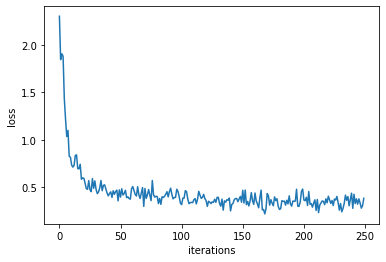

In [25]:
# Plot a loss curve
plt.plot(loss_history_sgd)
plt.ylabel('loss')
plt.xlabel('iterations')

In [26]:
print('Training accuracy: ', modelAccuracy(X_train,y_train,opt_theta_sgd))
print('Test accuracy: ', modelAccuracy(X_test,y_test,opt_theta_sgd))

(60000, 785)
(60000, 10)
(785, 10)
Training accuracy:  0.9069666666666667
(10000, 785)
(10000, 10)
(785, 10)
Test accuracy:  0.9092


### Visualize the learnt parameter


One of the benefits of a simple linear model like softmax regression is 
that we can visualize the parameters $\theta$ for each of the classes, 
and see what input it prefers for a strong output.


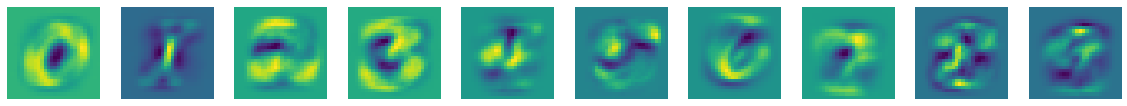

In [30]:
plt.figure(figsize=(20, 20))
num_classes = 10

for c in range(num_classes):
    f = plt.subplot(10, num_classes, 1 * num_classes + c + 1)
    f.axis('off')
    plt.imshow(np.reshape(opt_theta[1:,c],[28,28]))
plt.show()

### Evaluation

## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

_Image Classification - Softmax Regression_ <br/>
by _Benjamin Voigt, Klaus Strohmenger, Christian Herta_ <br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2018 _Benjamin Voigt, Klaus Strohmenger_

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.